- https://www.robots.ox.ac.uk/~vgg/hzbook/hzbook1/HZepipolar.pdf
- http://www.uio.no/studier/emner/matnat/its/UNIK4690/v16/forelesninger/lecture_7_1-epipolar-geometry.pdf
- https://github.com/marktao99/python/blob/master/CVP/samples/sfm.py#L85

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [1]:
# def get_row_A(pair, pair_prime):
#     x, y = pair[0], pair[1]
#     x_p, y_p = pair_prime[0], pair_prime[1]
#     return [x*x_p, y*x_p, x_p, x*y_p, y*y_p, y_p, x, y, 1]

# def build_A(pairs, pairs_prime):
#     A = np.zeros((pairs.shape[0], 9))
#     for i, (p, p_p) in enumerate(zip(pairs, pairs_prime)):
#         A[i] = get_row_A(p, p_p)
    
#     return A

def build_A(pairs, pairs_prime):
    x, y = pairs[:, 0], pairs[:, 1]
    x_p, y_p = pairs_prime[:, 0], pairs_prime[:, 1]
    
    A = np.vstack([x*x_p, y*x_p, x_p, x*y_p, y*y_p, y_p, x, y, np.ones(len(x))]).T
    return A

def get_fundemental_matrix(pairs, pairs_prime):
    A = build_A(pairs, pairs_prime)
    u, s, v = np.linalg.svd(A, full_matrices = False)
    f_bar = v[-1].reshape(3,3)
    u_hat, s_hat, v_hat = np.linalg.svd(f_bar, full_matrices = False)
    s_hat[-1] = 0
    f_hat = np.dot(u_hat, np.dot(np.diag(s_hat), v_hat))
    return f_hat

# def get_normalisation_matrix(points):
#     mean = np.mean(points, axis = 0)
#     s = np.sqrt(2) / np.std(points)
#     T = np.array([
#         [s, 0, -s * mean[0]],
#         [0, s, -s * mean[1]],
#         [0, 0, 1]
#     ])
#     return T

# def get_fundemental_matrix_normalised(pairs, pairs_prime):
    
#     T = get_normalisation_matrix(pairs[:, :2])
#     norm_pairs = np.dot(pairs, T.T)
    
#     T_prime = get_normalisation_matrix(pairs_prime[:, :2])
#     norm_pairs_prime = np.dot(pairs_prime, T_prime.T)
    
#     F = get_fundemental_matrix(norm_pairs, norm_pairs_prime)
    
#     denormed_F = np.dot(T_prime.T, np.dot(F, T))
    
#     return denormed_F

def get_normalisation_matrix(points):
    mean = np.mean(points, axis = 0)
    d = np.mean(np.linalg.norm(points - mean, axis = 1)) / np.sqrt(2)

    T = np.array([
        [1/d, 0, - mean[0] / d],
        [0, 1/d, - mean[1] / d],
        [0, 0, 1]
    ])
    return T

def get_fundemental_matrix_normalised(pairs, pairs_prime):
    
    T = get_normalisation_matrix(pairs[:, :2])
    norm_pairs = np.dot(pairs, T.T)
    
    T_prime = get_normalisation_matrix(pairs_prime[:, :2])
    norm_pairs_prime = np.dot(pairs_prime, T_prime.T)
    
    F = get_fundemental_matrix(norm_pairs, norm_pairs_prime)
    
    denormed_F = np.dot(T_prime.T, np.dot(F, T))    
    return denormed_F

def get_epipole(F):
    U,S,V = np.linalg.svd(F)
    e = V[-1] # as S[-1] ~ 0
    return e

# https://www.cs.auckland.ac.nz/courses/compsci773s1t/lectures/773-GGpdfs/773GG-FundMatrix-A.pdf

def get_rectification_matrix(F):
    R = np.zeros(F.shape)
    epipole = get_epipole(F)
    R[0] = epipole / np.linalg.norm(epipole)
    R[1] = np.array([-R[0, 1], R[0, 0], 0]) / np.linalg.norm(R[0, :2])
    R[2] = np.array([-R[0, 0] * R[0, 2], -R[0, 1] * R[0, 2], R[0, 0] ** 2 + R[0, 1] ** 2]) / (np.linalg.norm(epipole) * np.linalg.norm(R[0, :2]))
    return R

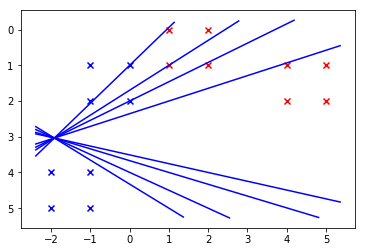

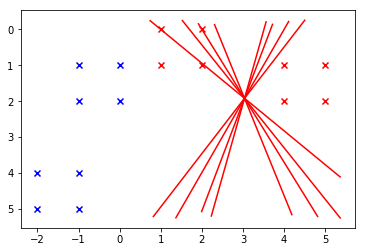

In [48]:
pairs = np.array([
    [0, 1],
    [0, 2],
    [1, 2],
    [1, 1],
    [1, 4],
    [1, 5],
    [2, 5],
    [2, 4]
])
pairs = np.concatenate((pairs, np.ones((pairs.shape[0], 1))), axis = 1)

plt.scatter(pairs[:, 1], pairs[:, 0], marker='x', c='r')

H = np.array([
    [0, 1, 0],
    [-1, 0, 0],
    [0, 0, 1]
]) # simple left rotation, no translation

pairs_prime = H.dot(pairs.T).T

plt.scatter(pairs_prime[:, 1], pairs_prime[:, 0], marker='x', c='b')
plt.gca().invert_yaxis()

F = get_fundemental_matrix_normalised(pairs, pairs_prime)
x_bound = plt.gca().get_xbound()
y_min, y_max = plt.gca().get_ybound()

for p in pairs_prime:
    line = np.dot(F.T, p)
    space = np.linspace(*x_bound, 100)
    
    eq = (line[2] + line[0] * space) / -line[1]
    selector = np.logical_and(y_min < eq, eq < y_max)
    space = space[selector]
    eq = eq[selector]
    
    plt.plot(space, eq, color='b')
    
plt.show()

plt.scatter(pairs[:, 1], pairs[:, 0], marker='x', c='r')
plt.scatter(pairs_prime[:, 1], pairs_prime[:, 0], marker='x', c='b')
plt.gca().invert_yaxis()

for p in pairs:
    line = np.dot(F, p)
    space = np.linspace(*x_bound, 100)
    
    eq = (line[2] + line[0] * space) / -line[1]
    selector = np.logical_and(y_min < eq, eq < y_max)
    space = space[selector]
    eq = eq[selector]
    
    plt.plot(space, eq, color='r')
    
plt.show()

Loading Annotator in data load mode...
Image Files:
> images/bridge_left.JPG
> images/bridge_right.JPG
Searching for annotation file: bridge_left_bridge_right_annotation.txt
> Annotation file found.


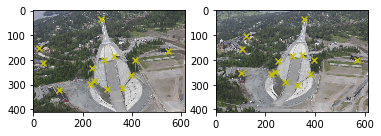

F:
[[ 9.85126582e-07  7.29009940e-06  8.72165767e-05]
 [-5.21191566e-06  2.46415966e-06 -6.80920369e-03]
 [ 4.32079712e-04  4.82828704e-03 -2.14032886e-01]]



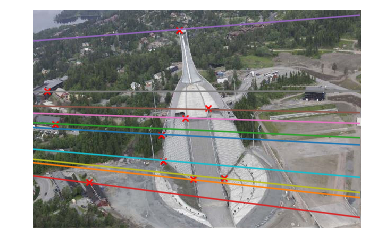

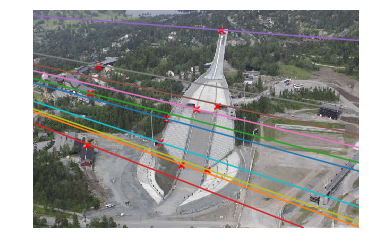

In [49]:
from src.annotator import Annotator
ann = Annotator('images/bridge_left.JPG', 'images/bridge_right.JPG', annotation_mode=False)
ann.display_images(show=True)
points = np.array(ann.coords)
images = ann.images

left = np.concatenate((points[0], np.ones((points[0].shape[0], 1))), axis=1)
right = np.concatenate((points[1], np.ones((points[1].shape[0], 1))), axis=1)

F = get_fundemental_matrix_normalised(left, right)
print('F:\n{}\n'.format(F))

num_points = 10

plt.imshow(images[0])
x_bound = plt.gca().get_xbound()
y_min, y_max = plt.gca().get_ybound()

for p, p_p in zip(left[:num_points], right[:num_points]):
    line = np.dot(F.T, p_p)
    space = np.linspace(*x_bound, 100)
    
    eq = (line[2] + line[0] * space) / - line[1]
    selector = np.logical_and(y_min < eq, eq < y_max)
    space = space[selector]
    eq = eq[selector]
    
    plt.plot(space, eq)
    plt.scatter(p[0], p[1], marker='x', c='r')
    plt.axis('off')
    
plt.show()
    
plt.imshow(images[1])
x_bound = plt.gca().get_xbound()
y_min, y_max = plt.gca().get_ybound()
for p, p_p in zip(left[:num_points], right[:num_points]):
    line = np.dot(F, p)
    space = np.linspace(*x_bound, 100)
    
    eq = (line[2] + line[0] * space) / - line[1]
    selector = np.logical_and(y_min < eq, eq < y_max)
    space = space[selector]
    eq = eq[selector]
    
    plt.plot(space, eq)
    plt.scatter(p_p[0], p_p[1], marker='x', c='r')
    plt.axis('off')

In [50]:
def fundemental_accuracy(pairs, pairs_prime, F):
    
    lines = np.dot(pairs, F.T)
    distances = np.abs(np.sum(lines * pairs_prime, axis = 1)) # pairwise dot products

    return distances.mean()

In [51]:
avgdist = fundemental_accuracy(left, right, F)
print('fundemental accuracy: {} (Maximum accuracy = 1)'.format(1 - avgdist))

fundemental accuracy: 0.9908044631767722 (Maximum accuracy = 1)


[[ 9.92224737e-01 -1.24456514e-01 -8.04509986e-04]
 [ 1.24456554e-01  9.92225058e-01  0.00000000e+00]
 [ 7.98254967e-04 -1.00126541e-04  9.99999676e-01]]


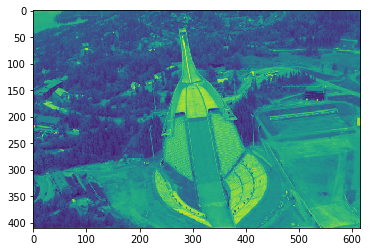

[[[-8.04510246e-04  0.00000000e+00  9.99999676e-01]
  [ 9.90629773e-01  1.24357326e-01  1.00079793e+00]
  [ 1.98048374e+00  2.48516430e-01  1.00159619e+00]
  ...
  [ 4.08840778e+02  5.12817104e+01  1.49012823e+00]
  [ 4.09287390e+02  5.13377298e+01  1.49092648e+00]
  [ 4.09733524e+02  5.13936891e+01  1.49172474e+00]]

 [[-1.25273608e-01  9.92324737e-01  9.99899550e-01]
  [ 8.66359164e-01  1.11590293e+00  1.00069780e+00]
  [ 1.85641115e+00  1.23928412e+00  1.00149606e+00]
  ...
  [ 4.08784725e+02  5.19510668e+01  1.49002810e+00]
  [ 4.09231397e+02  5.20067314e+01  1.49082635e+00]
  [ 4.09677591e+02  5.20623365e+01  1.49162461e+00]]

 [[-2.49767635e-01  1.98484823e+00  9.99799423e-01]
  [ 7.42063684e-01  2.10764698e+00  1.00059768e+00]
  [ 1.73231374e+00  2.23024994e+00  1.00139593e+00]
  ...
  [ 4.08728665e+02  5.26205130e+01  1.48992797e+00]
  [ 4.09175397e+02  5.26758230e+01  1.49072623e+00]
  [ 4.09621650e+02  5.27310737e+01  1.49152448e+00]]

 ...

 [[-5.28065698e+01  4.20991782e+02

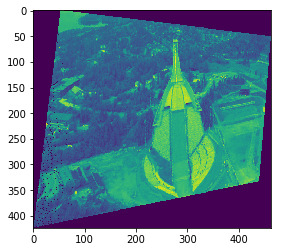

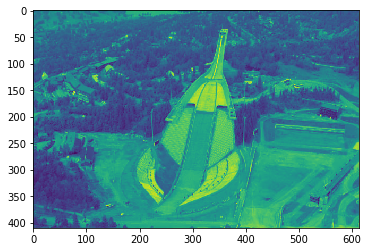

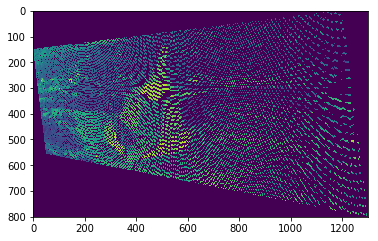

In [53]:
from src.utils import rgb_to_grey
R = get_rectification_matrix(F)
print(R)

im = rgb_to_grey(images[0])
plt.imshow(im)
plt.show()

height = im.shape[0]
width = im.shape[1]

mesh = np.meshgrid(np.arange(width), np.arange(height))
coords = np.concatenate((mesh[0][..., None], mesh[1][..., None], np.ones((*im.shape, 1))), axis=2) # create 2d array of [x y 1] coordinates

projected_coords = coords.dot(R.T) # project coordinate grid onto other image
projected_coords[:, :, :2] /= projected_coords[:, :, 2:] # divide x and y coords by z coord
print(projected_coords)

projected_coords = projected_coords.astype(int)

min_x, max_x = np.min(projected_coords[:, :, 0]), np.max(projected_coords[:, :, 0])
min_y, max_y = np.min(projected_coords[:, :, 1]), np.max(projected_coords[:, :, 1])

print(min_x, max_x, min_y, max_y)

box = np.zeros((max_y - min_y + 1, max_x - min_x + 1)) # create placeholder for pixels
box[projected_coords[:, :, 1] - min_y, projected_coords[:, :, 0] - min_x] = im # set projected coordinates to pixel values of original coordinates

# plt.figure(figsize=(10, 10))
plt.imshow(box)
# plt.scatter(right[:, 0] - min_x, right[:, 1] - min_y, marker='x', c='r')
plt.show()

im = rgb_to_grey(images[1])
plt.imshow(im)
plt.show()

height = im.shape[0]
width = im.shape[1]

mesh = np.meshgrid(np.arange(width), np.arange(height))
coords = np.concatenate((mesh[0][..., None], mesh[1][..., None], np.ones((*im.shape, 1))), axis=2) # create 2d array of [x y 1] coordinates

projected_coords = coords.dot(R) # project coordinate grid onto other image
projected_coords[:, :, :2] /= projected_coords[:, :, 2:] # divide x and y coords by z coord
projected_coords = projected_coords.astype(int)

min_x, max_x = np.min(projected_coords[:, :, 0]), np.max(projected_coords[:, :, 0])
min_y, max_y = np.min(projected_coords[:, :, 1]), np.max(projected_coords[:, :, 1])



box = np.zeros((max_y - min_y + 1, max_x - min_x + 1)) # create placeholder for pixels
box[projected_coords[:, :, 1] - min_y, projected_coords[:, :, 0] - min_x] = im # set projected coordinates to pixel values of original coordinates

# plt.figure(figsize=(10, 10))
plt.imshow(box)
# plt.scatter(left[:, 0] - min_x, left[:, 1] - min_y, marker='x', c='r')
plt.show()

c:\users\rameg\miniconda2\envs\patternrec\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


0 256
117.33629014756944 52.995515371212065


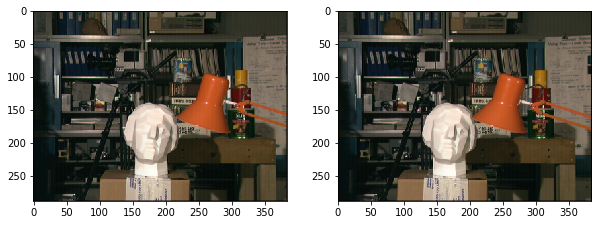

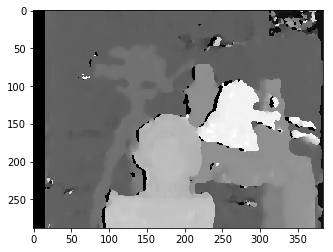

In [31]:
import cv2
from scipy.misc import imread
from src.utils import plot_side_by_side

# image_paths = ['images/coffee_left.jpg', 'images/coffee_right.jpg']
image_paths = ['images/tsukuba/scene1.row3.col1.ppm', 'images/tsukuba/scene1.row3.col2.ppm']
images = [imread(p) for p in image_paths]
norm = lambda im: ((im - im.min()) / (im.max() - im.min()) * 255).astype(np.uint8)
to_grey = lambda im: norm(0.299 * im[:, :, 0] + 0.587 * im[:, :, 1] + 0.114 * im[:, :, 2])

stereo = cv2.StereoSGBM_create(numDisparities=16, blockSize=11, )

min_height = min([im.shape[0] for im  in images])
min_width = min([im.shape[1] for im in images])
rsz_images = [to_grey(im[:min_height, :min_width]) for im in images]

disparity = stereo.compute(rsz_images[0], rsz_images[1])
disparity += 16

print(disparity.min(), disparity.max())
print(disparity.mean(), disparity.std())

plot_side_by_side(images[0], images[1])
plt.show()
plt.imshow(disparity, cmap='gray')